CIMP6 databass

In [ ]:
!pip install matplotlib==3.3.4
!pip install intake
!pip install xarray
!pip install proplot
!pip install cartopy
!pip install ipywidgets
!pip install canvas

In [10]:
import intake
import xarray as xr 
import matplotlib.pyplot as plt
import proplot as plot 
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import ipywidgets as widgets
from matplotlib.colors import BoundaryNorm, ListedColormap
from ipywidgets import interact


In [11]:
# necessary url
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"

dataframe = intake.open_esm_datastore(url)


In [12]:
models = dataframe.search(experiment_id='historical',
                              table_id='Amon',
                              variable_id='tas',
                              institution_id='NCAR',
                              member_id='r11i1p1f1')


 https://aims2.llnl.gov/metagrid/search/?project=CMIP6

In [13]:
models 


,unique
activity_id,1
institution_id,1
source_id,1
experiment_id,1
member_id,1
table_id,1
variable_id,1
grid_label,1
zstore,1
dcpp_init_year,0


## Load dataset

In [14]:
datasets = models.to_dataset_dict()



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [35]:
datasets.keys()


dict_keys(['CMIP.NCAR.CESM2.historical.Amon.gn'])

In [36]:
dset = datasets['CMIP.NCAR.CESM2.historical.Amon.gn']
dset

<xarray.Dataset>
Dimensions:         (lat: 192, nbnd: 2, lon: 288, member_id: 1,
                     dcpp_init_year: 1, time: 1980)
Coordinates:
  * lat             (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
    lat_bnds        (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon             (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    lon_bnds        (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time            (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds       (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id       (member_id) object 'r11i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Dimensions without coordinates: nbnd
Data variables:
    tas             (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
Attributes: (12/62)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    branch_time_in_parent:            219000.0
    case_id:                          972
    ...                               ...
    intake_esm_attrs:variable_id:     tas
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NCAR/CESM2/histor...
    intake_esm_attrs:version:         20190514
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2.historical.Amon.gn

In [93]:
tas_min = dset.tas.min().values
tas_max = dset.tas.max().values

def theta (t):
    dset.tas.isel(time=t).plot(vmin=tas_min, vmax=tas_max)
widgets.interact(theta, t=widgets.Play(min=0, max=1978, fps=3))


interactive(children=(Play(value=0, description='t', max=1978), Output()), _dom_classes=('widget-interact',))

<function __main__.theta(t)>

In [37]:
tas_min = dset.tas.min().values
tas_max = dset.tas.max().values

def theta(t):
    plt.figure(figsize=(10,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    dset.tas.isel(time=t).plot(ax=ax, transform=ccrs.PlateCarree(), vmin=tas_min, vmax=tas_max)
    plt.show()

widgets.interact(theta, t=widgets.Play(min=0, max=dset.time.size - 1, fps=50))

interactive(children=(Play(value=0, description='t', max=1979), Output()), _dom_classes=('widget-interact',))

<function __main__.theta(t)>

In [88]:
# Sample every 12th frame
dset = dset.isel(time=slice(11, None, 12))

In [38]:
# Convert temperature from Kelvin to Celsius
dset['tas'] = dset['tas'] - 273.15

In [39]:
dset = dset.rename({'tas': 'Near Surface Air Temperature [C]'})

In [20]:
time_steps = dset['time'].size
print(time_steps)

1980


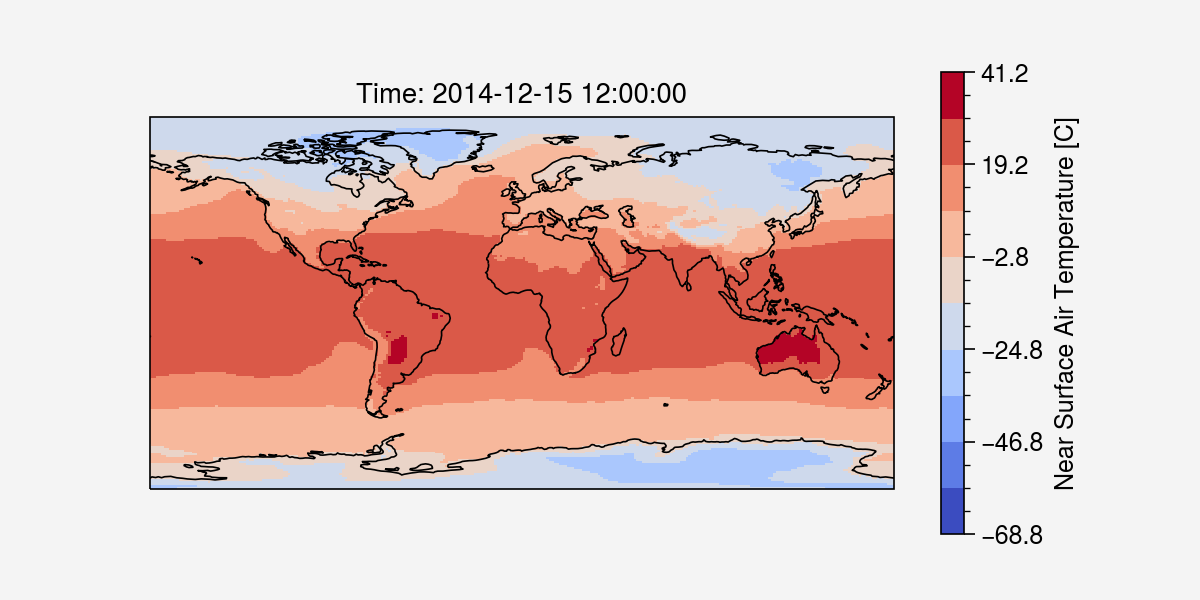

In [91]:
import matplotlib.animation as animation
from IPython.display import HTML

cmap = plt.get_cmap('coolwarm', 10) 

boundaries = np.arange(tas_min, tas_max, 11) 

norm = BoundaryNorm(boundaries, cmap.N)

fig, ax = plt.subplots(figsize=(6,3), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

plot = dset['Near Surface Air Temperature [C]'].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), norm=norm, cmap=cmap, add_colorbar=False)

def update(t):
    data = dset['Near Surface Air Temperature [C]'].isel(time=t)
    plot.set_array(data.to_masked_array().ravel())
    # Here we update the title for each frame
    ax.set_title(f"Time: {dset.time.values[t]}")
    return plot,

ani = animation.FuncAnimation(fig, update, frames=range(0, 165, 1), blit=True)

cbar = plt.colorbar(plot, ax=ax, orientation='vertical')
cbar.set_label('Near Surface Air Temperature [C]')

ani.save('animation.gif', writer='pillow', fps=3)

In [40]:
dset_yearly = dset.resample(time='Y').mean()

baseline = dset_yearly.sel(time=slice('1850-01-01', '1850-12-31')).mean(dim='time')
dset_yearly = dset_yearly - baseline

tas_min = dset_yearly['Near Surface Air Temperature [C]'].min().compute().item()
tas_max = dset_yearly['Near Surface Air Temperature [C]'].max().compute().item()


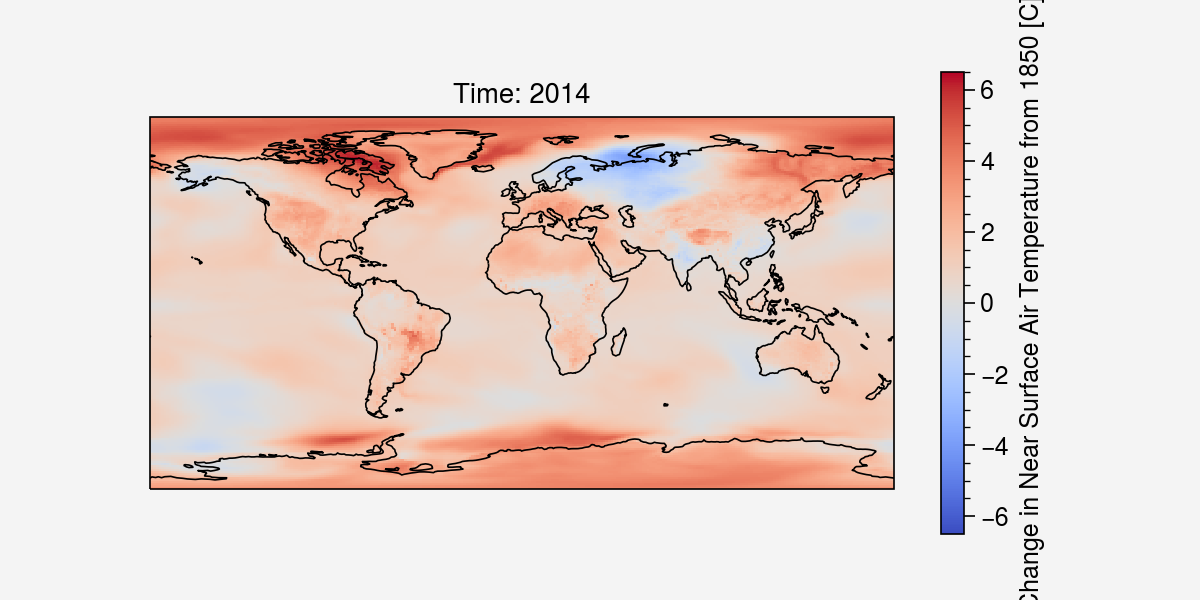

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm
import matplotlib.animation as animation

tas_abs_max = max(abs(tas_min), abs(tas_max))
boundaries = np.linspace(-tas_abs_max, tas_abs_max, 11) 

norm = TwoSlopeNorm(vmin=-6.5, vcenter=0, vmax=6.5)

fig, ax = plt.subplots(figsize=(6,3), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

cmap = plt.get_cmap('coolwarm')

plot = dset_yearly['Near Surface Air Temperature [C]'].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), norm=norm, cmap=cmap, add_colorbar=False)

def update(t):
    data = dset_yearly['Near Surface Air Temperature [C]'].isel(time=t)
    plot.set_array(data.to_masked_array().ravel())
    ax.set_title(f"Time: {dset_yearly.time.values[t].year}")
    return plot,

ani = animation.FuncAnimation(fig, update, frames=range(0, len(dset_yearly.time), 1), blit=True)

cbar = plt.colorbar(plot, ax=ax, orientation='vertical')
cbar.set_label('Change in Near Surface Air Temperature from 1850 [C]')
ani.save('animation.gif', writer='pillow', fps=3)

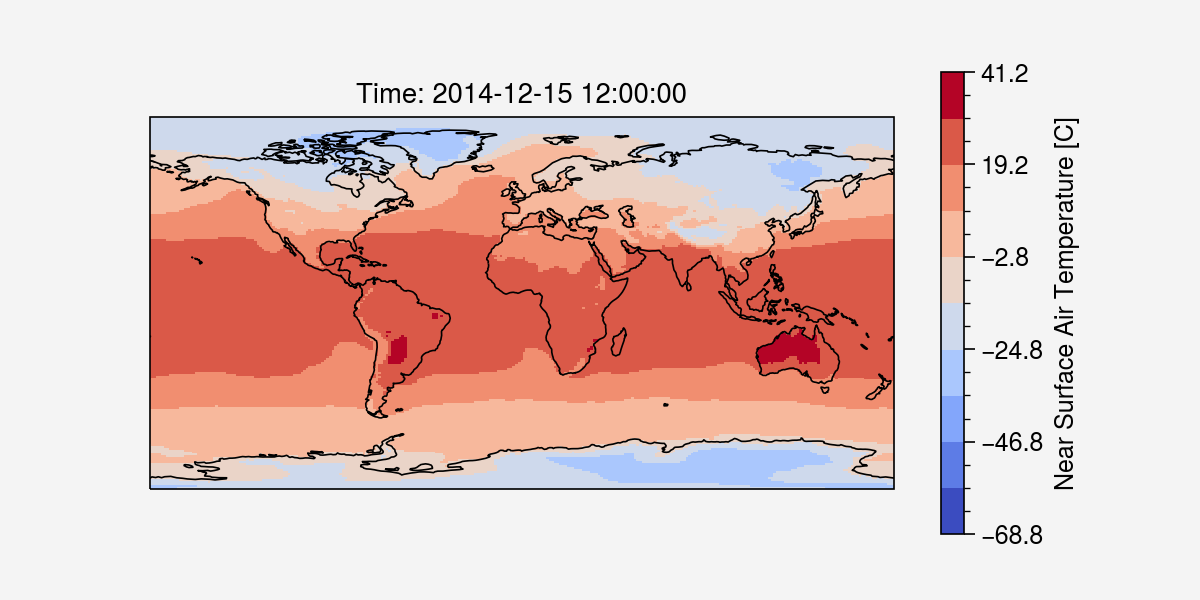

In [33]:
import matplotlib.animation as animation
from IPython.display import HTML

cmap = plt.get_cmap('coolwarm', 10)  # 9 distinct colors

tas_min = dset['Near Surface Air Temperature [C]'].min().values
tas_max = dset['Near Surface Air Temperature [C]'].max().values

boundaries = np.arange(tas_min, tas_max, 11)  # Change of color for every 10 units

norm = BoundaryNorm(boundaries, cmap.N)

fig, ax = plt.subplots(figsize=(6,3), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

plot = dset['Near Surface Air Temperature [C]'].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), norm=norm, cmap=cmap, add_colorbar=False)

def update(t):
    data = dset['Near Surface Air Temperature [C]'].isel(time=t)
    plot.set_array(data.to_masked_array().ravel())
    
    ax.set_title(f"Time: {dset.time.values[t]}")
    return plot,


ani = animation.FuncAnimation(fig, update, frames=range(0, 1980, 1), blit=True)

cbar = plt.colorbar(plot, ax=ax, orientation='vertical')
cbar.set_label('Near Surface Air Temperature [C]')

ani.save('animation.gif', writer='pillow', fps=3)

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

cmap = plt.get_cmap('coolwarm', 10)  # 9 distinct colors

tas_min = dset['Near Surface Air Temperature [C]'].min().values
tas_max = dset['Near Surface Air Temperature [C]'].max().values

boundaries = np.arange(tas_min, tas_max, 11)  # Change of color for every 10 units

norm = BoundaryNorm(boundaries, cmap.N)

fig, ax = plt.subplots(figsize=(6,3), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

plot = dset['Near Surface Air Temperature [C]'].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), norm=norm, cmap=cmap, add_colorbar=False)

def update(t):
    data = dset['Near Surface Air Temperature [C]'].isel(time=t)

    ax.set_title(f"Time: {dset.time.values[t]}")
    return plot,

ani = animation.FuncAnimation(fig, update, frames=range(0, 1980, 1), blit=True)

cbar = plt.colorbar(plot, ax=ax, orientation='vertical')
cbar.set_label('Near Surface Air Temperature [C]')

ani.save('animation.gif', writer='pillow', fps=3)

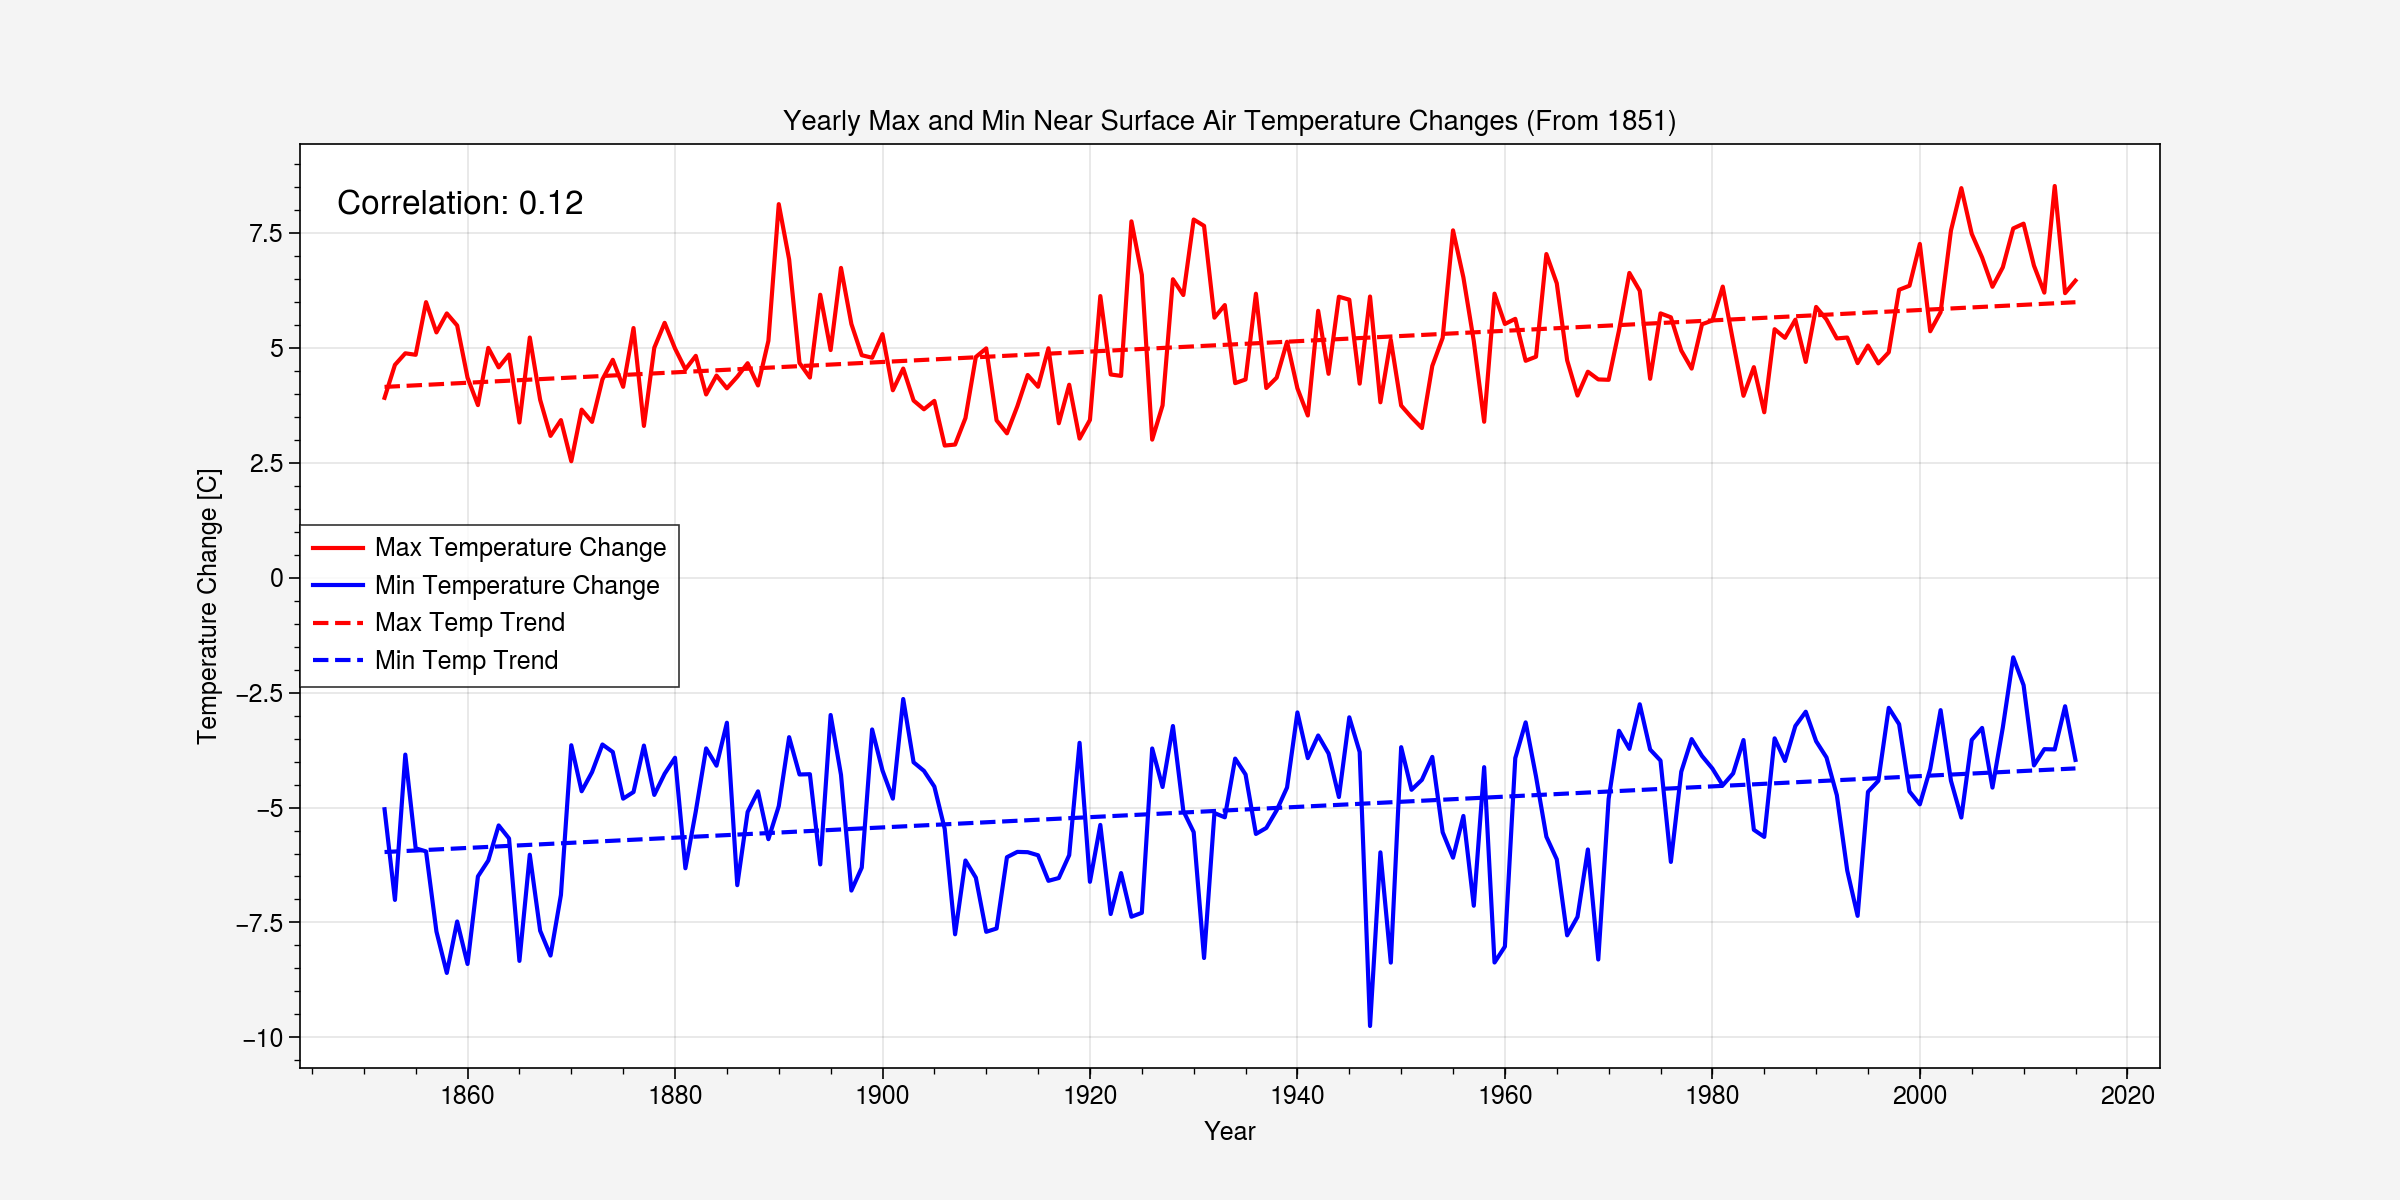

In [42]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np

yearly_max_series = yearly_max_series[yearly_max_series.index.year >= 1971]
yearly_min_series = yearly_min_series[yearly_min_series.index.year >= 1971]

correlation = yearly_max_series.corr(yearly_min_series)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(yearly_max_series.index, yearly_max_series, label='Max Temperature Change', color='red')
ax.plot(yearly_min_series.index, yearly_min_series, label='Min Temperature Change', color='blue')

ax.set_title('Yearly Max and Min Near Surface Air Temperature Changes (From 1851)')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature Change [C]')

ax.text(0.02, 0.95, f'Correlation: {correlation:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

z = np.polyfit(mdates.date2num(yearly_max_series.index), yearly_max_series.values, 1)
p = np.poly1d(z)
ax.plot(yearly_max_series.index, p(mdates.date2num(yearly_max_series.index)), "r--", label='Max Temp Trend')

z = np.polyfit(mdates.date2num(yearly_min_series.index), yearly_min_series.values, 1)
p = np.poly1d(z)
ax.plot(yearly_min_series.index, p(mdates.date2num(yearly_min_series.index)), "b--", label='Min Temp Trend')

ax.legend()

plt.show()

fig.savefig('temperature_changes.png', dpi=300)